In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816190644.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816191719.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816184716.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816184836.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816181247.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816190707.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816184311.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816191139.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816190710.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816190058.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816181426.jpg
/kaggle/input/vggdataset/dataset/Leaf that uses to make tea/IMG20230816183137.jpg
/kaggle/input/vg

In [2]:
!pip install torchinfo

In [3]:
# Install necessary libraries if not present (Run this first)
# !pip install ultralytics torch torchvision numpy pandas scikit-learn split-folders

import numpy as np
import pandas as pd
import os
import time
import random
import glob
from tqdm.notebook import tqdm
import platform
import psutil
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from itertools import cycle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.optim as optim


# --- SYSTEM AND PROJECT CONFIGURATION ---
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- YOUR CORRECTED DATA PATHS ---
data_dir = "/kaggle/input/vggdataset/dataset" # Raw dataset path
output_dir = "/kaggle/working/processed-dataset-vgg16"
checkpoints_path = "/kaggle/working/checkpoints-vgg16"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)

# --- HYPERPARAMETERS (Consistent settings) ---
train_batch = 8
test_batch = 16
total_class = 2 # <--- CORRECTED: Your dataset has 2 classes
learning_rate = 0.0001
decay = 1e-4
epoch = 30       
patience = 15
IMG_SIZE = 64    # Optimized for CPU

Device: cpu


In [4]:
# --- Data Loading and Splitting Logic ---
def load_split(split_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_split(data_dir)

# 70/15/15 Split
train_dataframe, temp_dataframe = train_test_split(data, test_size=0.30, stratify=data['label'], random_state=42)
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.50, stratify=temp_dataframe['label'], random_state=42)

print(f"Original Data Counts:\nTrain: {len(train_dataframe)}, Val: {len(validation_dataframe)}, Test: {len(test_dataframe)}")

# Data Preprocessing (Resizing images to 64x64)
def data_preprocess(df, split_name, size=(IMG_SIZE, IMG_SIZE), quality=90):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)
    processed_file_paths = []
    
    # Only process if the directory is empty
    if not os.path.exists(os.path.join(split_dir, df['label'].iloc[0])):
        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
            label_dir = os.path.join(split_dir, row['label'])
            os.makedirs(label_dir, exist_ok=True)
            try:
                img = Image.open(row['file_path']).convert("RGB")  
                img = img.resize(size, Image.Resampling.LANCZOS)
                save_path = os.path.join(label_dir, os.path.basename(row['file_path']))
                img.save(save_path, optimize=True, quality=quality)
                processed_file_paths.append(save_path)
            except Exception as e:
                pass
        df['file_path'] = processed_file_paths
    return df

train_dataframe = data_preprocess(train_dataframe.copy(), "train")
validation_dataframe = data_preprocess(validation_dataframe.copy(), "val")
test_dataframe = data_preprocess(test_dataframe.copy(), "test")


# --- Data Loader Setup ---
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}
        self.class_names = [label for label, idx in self.label_map.items()]

    def __len__(self): return len(self.dataframe)
    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert('RGB')
        label = self.label_map[self.dataframe.iloc[index]['label']]
        return self.transform(image), label

def data_transform(train_df, val_df, test_df):
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE), transforms.CenterCrop(IMG_SIZE), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15), transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.1)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset(train_df, train_transform)
    valid_dataset = ImageDataset(val_df, transform)
    test_dataset = ImageDataset(test_df, transform)
        
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(valid_dataset, batch_size=test_batch, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)
    
    return train_dataloader, validation_dataloader, test_dataloader, train_dataset.class_names

train_dataloader, validation_dataloader, test_dataloader, class_names = data_transform(train_dataframe, validation_dataframe, test_dataframe)
print(f"Class Names for reporting: {class_names}")

Original Data Counts:
Train: 522, Val: 112, Test: 113


Processing train:   0%|          | 0/522 [00:00<?, ?it/s]

Processing val:   0%|          | 0/112 [00:00<?, ?it/s]

Processing test:   0%|          | 0/113 [00:00<?, ?it/s]

Class Names for reporting: ['Leaf that not to be used to make tea', 'Leaf that uses to make tea']


In [5]:
# --- TRAIN MODEL FUNCTION (Robust Early Stopping) ---
def train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=30, early_stop_patience=15, checkpoints_path="checkpoints"):
    
    if 'device' not in globals():
        global device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    
    model_type = model.__class__.__name__
    filepath = os.path.join(checkpoints_path, f"{model_type}_best_model.pt")
    os.makedirs(checkpoints_path, exist_ok=True)
    print(f"Starting training on {device}...")

    for epoch_num in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / total_train

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_val_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        
        print(f'\nEpoch {epoch_num+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

        # --- Early Stopping and Checkpoint Logic ---
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch_num + 1
            checkpoint = {
                "epoch": epoch_num + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": best_val_acc
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"EARLY STOP COUNTER {consecutive_no_improvement} / {early_stop_patience}")

        if consecutive_no_improvement >= early_stop_patience:
            print(f"Early stopping triggered. Training stopped.")
            break

    return best_val_acc


# --- VGG16 SCRATCH MODEL DEFINITION (Fixed with BatchNorm and 2 classes) ---
class VGG16_Scratch(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_Scratch, self).__init__()
        
        # VGG16 Feature Extractor with BatchNorm (improves stability)
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], batch_norm=True)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) 
        
        # Classifier Layer with Dropout (Fixed for 2 classes)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5), 
            nn.Linear(4096, num_classes) # Correctly set to 2
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M': layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [6]:
print("\n--- Starting VGG16 Scratch Model Training (Task 3) ---")

model_vgg16_scratch = VGG16_Scratch(num_classes=total_class).to(device)

# --- CLASS WEIGHTS (Fixing Bias using Inverse Frequency) ---
class_counts = train_dataframe['label'].value_counts()
class_labels = class_counts.index.tolist()

total_samples = len(train_dataframe)
class_weights_list = [total_samples / class_counts[label] for label in class_labels]
normalized_weights = [w / sum(class_weights_list) * total_class for w in class_weights_list]
class_weights = torch.tensor(normalized_weights, dtype=torch.float).to(device)
print(f"Calculated Class Weights for {class_labels}: {class_weights.cpu().numpy()}")

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer_vgg16 = optim.Adam(model_vgg16_scratch.parameters(), lr=learning_rate, weight_decay=decay)

# --- Start Training ---
best_vgg16_acc = train_model(
    model_vgg16_scratch, 
    criterion, 
    optimizer_vgg16, 
    train_dataloader, 
    validation_dataloader, 
    num_epochs=epoch,
    early_stop_patience=patience,
    checkpoints_path=checkpoints_path
)


--- Starting VGG16 Scratch Model Training (Task 3) ---
Calculated Class Weights for ['Leaf that not to be used to make tea', 'Leaf that uses to make tea']: [0.9425287 1.0574713]
Starting training on cpu...


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 1/30 - Train Loss: 1.0613 | Val Loss: 0.5332 | Val Acc: 0.8214
Best model saved at epoch 1 with validation accuracy: 0.8214


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 2/30 - Train Loss: 0.5003 | Val Loss: 0.7338 | Val Acc: 0.7321
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 3/30 - Train Loss: 1.0729 | Val Loss: 0.5056 | Val Acc: 0.7321
EARLY STOP COUNTER 2 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 4/30 - Train Loss: 0.9604 | Val Loss: 0.6212 | Val Acc: 0.7500
EARLY STOP COUNTER 3 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 5/30 - Train Loss: 0.4999 | Val Loss: 0.6655 | Val Acc: 0.7857
EARLY STOP COUNTER 4 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 6/30 - Train Loss: 0.4487 | Val Loss: 0.5985 | Val Acc: 0.8036
EARLY STOP COUNTER 5 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 7/30 - Train Loss: 0.3493 | Val Loss: 0.7354 | Val Acc: 0.8304
Best model saved at epoch 7 with validation accuracy: 0.8304


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 8/30 - Train Loss: 0.6722 | Val Loss: 0.6159 | Val Acc: 0.8661
Best model saved at epoch 8 with validation accuracy: 0.8661


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 9/30 - Train Loss: 0.3427 | Val Loss: 0.5502 | Val Acc: 0.7946
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 10/30 - Train Loss: 0.3186 | Val Loss: 0.3804 | Val Acc: 0.8214
EARLY STOP COUNTER 2 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 11/30 - Train Loss: 0.4114 | Val Loss: 0.3353 | Val Acc: 0.8839
Best model saved at epoch 11 with validation accuracy: 0.8839


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 12/30 - Train Loss: 0.4617 | Val Loss: 0.8468 | Val Acc: 0.6339
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 13/30 - Train Loss: 0.3130 | Val Loss: 0.3439 | Val Acc: 0.8661
EARLY STOP COUNTER 2 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 14/30 - Train Loss: 0.4726 | Val Loss: 0.4917 | Val Acc: 0.8393
EARLY STOP COUNTER 3 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 15/30 - Train Loss: 0.4505 | Val Loss: 0.4007 | Val Acc: 0.8482
EARLY STOP COUNTER 4 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 16/30 - Train Loss: 0.4559 | Val Loss: 0.3789 | Val Acc: 0.8661
EARLY STOP COUNTER 5 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 17/30 - Train Loss: 0.3176 | Val Loss: 0.2520 | Val Acc: 0.9018
Best model saved at epoch 17 with validation accuracy: 0.9018


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 18/30 - Train Loss: 0.2507 | Val Loss: 0.2112 | Val Acc: 0.9286
Best model saved at epoch 18 with validation accuracy: 0.9286


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 19/30 - Train Loss: 0.3501 | Val Loss: 0.5250 | Val Acc: 0.8304
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 20/30 - Train Loss: 0.5643 | Val Loss: 0.3439 | Val Acc: 0.8750
EARLY STOP COUNTER 2 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 21/30 - Train Loss: 0.3650 | Val Loss: 0.2637 | Val Acc: 0.8750
EARLY STOP COUNTER 3 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 22/30 - Train Loss: 0.3008 | Val Loss: 0.3502 | Val Acc: 0.8036
EARLY STOP COUNTER 4 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 23/30 - Train Loss: 0.2813 | Val Loss: 0.2066 | Val Acc: 0.9464
Best model saved at epoch 23 with validation accuracy: 0.9464


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 24/30 - Train Loss: 0.2905 | Val Loss: 0.2639 | Val Acc: 0.8750
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 25/30 - Train Loss: 0.2361 | Val Loss: 0.1852 | Val Acc: 0.9554
Best model saved at epoch 25 with validation accuracy: 0.9554


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 26/30 - Train Loss: 0.2878 | Val Loss: 0.2454 | Val Acc: 0.8750
EARLY STOP COUNTER 1 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 27/30 - Train Loss: 0.4137 | Val Loss: 0.3487 | Val Acc: 0.8304
EARLY STOP COUNTER 2 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 28/30 - Train Loss: 0.3560 | Val Loss: 0.2524 | Val Acc: 0.8750
EARLY STOP COUNTER 3 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 29/30 - Train Loss: 0.2135 | Val Loss: 0.8622 | Val Acc: 0.7500
EARLY STOP COUNTER 4 / 15


  0%|          | 0/66 [00:00<?, ?it/s]


Epoch 30/30 - Train Loss: 0.3295 | Val Loss: 0.2660 | Val Acc: 0.8750
EARLY STOP COUNTER 5 / 15


Model loaded successfully (Best epoch: 25, Val Acc: 0.9554)

--- VGG16 Scratch Evaluation Report (Task 3) ---
Overall Test Accuracy: 0.9292

--- Classification Report ---
                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       0.96      0.90      0.93        60
          Leaf that uses to make tea       0.89      0.96      0.93        53

                            accuracy                           0.93       113
                           macro avg       0.93      0.93      0.93       113
                        weighted avg       0.93      0.93      0.93       113


--- Confusion Matrix ---
[[54  6]
 [ 2 51]]

Test AUC: 0.9692
Total Testing Time: 7.61 seconds


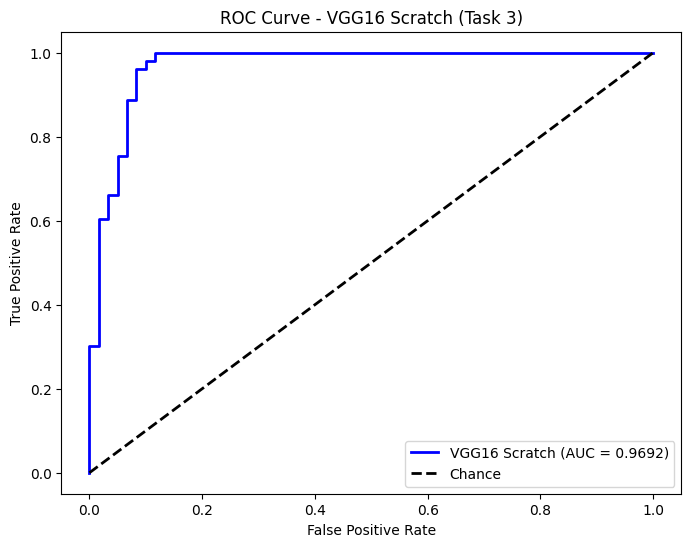

In [7]:
# --- VGG16 FINAL EVALUATION SCRIPT ---

# 1. Load the Best Model Checkpoint
filepath = os.path.join(checkpoints_path, "VGG16_Scratch_best_model.pt") 

model_vgg16_scratch_eval = VGG16_Scratch(num_classes=total_class).to(device)

try:
    checkpoint = torch.load(filepath, map_location=device)
    model_vgg16_scratch_eval.load_state_dict(checkpoint["model_weight"])
    print(f"Model loaded successfully (Best epoch: {checkpoint.get('epoch', 'N/A')}, Val Acc: {checkpoint.get('val_acc', 'N/A'):.4f})")
except Exception as e:
    print(f"❌ ERROR: Failed to load VGG16 checkpoint. Check the path/filename, model architecture, and checkpoint key.")
    raise RuntimeError("Checkpoint loading failed. Evaluation cannot proceed.")

# 2. Evaluation Loop
y_true, y_pred, y_pred_probs = [], [], []
model_vgg16_scratch_eval.eval()
test_start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_vgg16_scratch_eval(inputs)
        
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

testing_time = time.time() - test_start_time

# 3. Report All Metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

print("\n--- VGG16 Scratch Evaluation Report (Task 3) ---")

# Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n--- Confusion Matrix ---")
print(cm)

# AUC Score (Binary Classification)
try:
    # AUC for binary classification uses the probability of the positive class (index 1)
    auc_score = roc_auc_score(y_true, y_pred_probs[:, 1]) 
    print(f"\nTest AUC: {auc_score:.4f}")
except Exception as e:
    print(f"\nCould not calculate AUC. Error: {e}")

print(f"Total Testing Time: {testing_time:.2f} seconds")


# 4. ROC Curve Visualization
plt.figure(figsize=(8, 6))
# For 2 classes, index 1 is the positive class
class_probs = y_pred_probs[:, 1]
fpr, tpr, _ = roc_curve(y_true, class_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'VGG16 Scratch (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve - VGG16 Scratch (Task 3)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()